In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as im

import numpy as np
import glob
import os
import sys
import cv2

from model_config.model import *

from scipy import io

In [2]:
print(cv2.getVersionString())

4.5.5


# 데이터 불러오기

![alt text](https://ibug.doc.ic.ac.uk/media/uploads/images/ear-examplar.png "ears_data_set_image")

출처 : https://ibug.doc.ic.ac.uk/resources/ibug-ears/

In [11]:
os.listdir('data/CollectionA/train')[:5]
glob.glob('data/CollectionA/train/*.png')[:5]

['data/CollectionA/train/train_0319.png',
 'data/CollectionA/train/train_0077.png',
 'data/CollectionA/train/train_0390.png',
 'data/CollectionA/train/train_0005.png',
 'data/CollectionA/train/train_0392.png']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1400, 1200, 3)


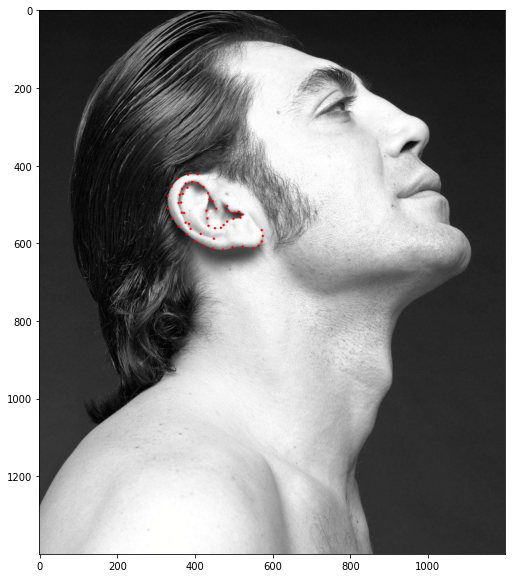

In [3]:
data_dir = 'data/CollectionA/train/'
landmark_dir = '../DATA_SET/300W-LP/300W_LP/landmarks/AFW/'

file_list = os.listdir(data_dir)
name_list = list(set(map(lambda x : x[:-4], file_list)))

# temp = glob.glob('data/CollectionA/train/*.pts')[0]
def read_pts(filename):
    return np.loadtxt(filename, comments=("version:", "n_points:", "{", "}"))
# read_pts(temp)

for name in name_list[:1]:
    image = im.imread(os.path.join(data_dir, name+'.png'))
    print(image.shape)

    label = read_pts(data_dir+name+'.pts')
    for x, y in label:
        cv2.circle(image, (int(x), int(y)), 3, (255, 0, 0), -1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.show()

In [4]:
# data_dir = '../DATA_SET/Ear_data/train/o_images/'
# landmark_dir = '../DATA_SET/Ear_data/train/o_landmarks/'

data_dir = '../DATA_SET/300W-LP/300W_LP/AFW/'
landmark_dir = '../DATA_SET/300W-LP/300W_LP/landmarks/AFW/'

file_list = os.listdir(data_dir)
name_list = list(set(map(lambda x : x[:-4], file_list)))
    
for name in name_list[:1]:
    image = im.imread(os.path.join(data_dir, name+'.png'))
    print(image.shape)
    with open(landmark_dir+name+'.txt', 'r') as f:
        lines_list = f.readlines()
        temp = list(map(lambda l: list(map(float, l.split(' '))), lines_list[3:-1]))
        print(np.array(temp).shape)
        for line in lines_list[3:-1]:
            x, y = list(map(float,line.split(' ')))
            image = cv2.circle(image, (int(x), int(y)), 3, (1, 0, 0), -1)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../DATA_SET/300W-LP/300W_LP/AFW/AFW_22699817_1_14.png'

In [4]:
landmark = []
for line in lines_list[3:-1]:
    x, y = list(map(float,line.split(' ')))
    landmark.append([int(x), int(y)])
landmark = np.array(landmark)
min_x = np.min(landmark[:,0])
max_x = np.max(landmark[:,0])
min_y = np.min(landmark[:,1])
max_y = np.max(landmark[:,1])
print(min_x, max_x, min_y, max_y)

image_left = image[:,0:min_x,:]
image_right = image[:,max_x:-1,:]
image_mid = image[:,min_x:max_x:3,:]

new_image = np.concatenate((image_left, image_mid, image_right), axis = 1)

plt.figure(figsize=(10, 10))
plt.imshow(new_image)
plt.show()

landmark = (landmark-np.array([min_x,0]))/np.array([3,1])+np.array([min_x,0])
for x,y in landmark:
    new_image = cv2.circle(new_image, (int(x), int(y)), 3, (0, 1, 0), -1)
plt.figure(figsize=(10, 10))
plt.imshow(new_image)
plt.show()

NameError: name 'lines_list' is not defined

# 모델 설정 및 파라미터 설정

In [5]:
INPUT_SIZE = 200
MAP_SIZE = 100
MAP_SIGMA = 2.5

LANDMARK_NUM = list(range(68))#[4,9,16,36] # 원하는 point 를 입력
LANDMARK_SIZE = len(LANDMARK_NUM) # ear : 55 / face : 68
LEARNING_RATE = 0.0001
BATCH_SIZE = 10
EPOCH = 200

split_rate = 0.9

In [6]:
#-------------------------------------- model setting
#------------------------- feature map
x = tf.keras.Input(shape=(INPUT_SIZE, INPUT_SIZE, 3), name='input_layer')
h = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding = 'same')(x)
h_1 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h = tf.keras.layers.MaxPool2D()(h_1)

h = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h_2 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h = tf.keras.layers.MaxPool2D()(h_2)

h = tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h_3 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h = tf.keras.layers.MaxPool2D()(h_3)

h = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding = 'same')(h)

h = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding = 'same')(h)
feature_map = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding = 'same', name='feature_map')(h)

#------------------------- stage1
h = tf.keras.layers.Conv2D(512, kernel_size=(1,1), activation='relu', name='stage_1')(feature_map)

h = tf.keras.layers.Conv2D(256, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_3])

h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_2])

s1 = tf.keras.layers.Conv2D(LANDMARK_SIZE, kernel_size=(1,1), name='s1')(h)

s1_h = tf.keras.layers.MaxPool2D((4,4))(s1)

#------------------------- stage2
h = tf.keras.layers.concatenate([feature_map, s1_h], axis=-1, name='stage_2')
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)

h = tf.keras.layers.Conv2D(256, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_3])

h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_2])

s2 = tf.keras.layers.Conv2D(LANDMARK_SIZE, kernel_size=(1,1), name='s2')(h)

s2_h = tf.keras.layers.MaxPool2D((4,4))(s2)

#------------------------- stage3
h = tf.keras.layers.concatenate([feature_map, s2_h], axis=-1, name='stage_3')
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)

h = tf.keras.layers.Conv2D(256, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_3])

h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_2])

s3 = tf.keras.layers.Conv2D(LANDMARK_SIZE, kernel_size=(1,1), name='s3')(h)

s3_h = tf.keras.layers.MaxPool2D((4,4))(s3)

#------------------------- stage4
h = tf.keras.layers.concatenate([feature_map, s3_h], axis=-1, name='stage_4')
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)

h = tf.keras.layers.Conv2D(256, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_3])

h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_2])

s4 = tf.keras.layers.Conv2D(LANDMARK_SIZE, kernel_size=(1,1), name='s4')(h)

s4_h = tf.keras.layers.MaxPool2D((4,4))(s4)

#------------------------- stage5
h = tf.keras.layers.concatenate([feature_map, s4_h], axis=-1, name='stage_5')
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)

h = tf.keras.layers.Conv2D(256, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_3])

h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_2])

s5 = tf.keras.layers.Conv2D(LANDMARK_SIZE, kernel_size=(1,1), name='s5')(h)

s5_h = tf.keras.layers.MaxPool2D((4,4))(s5)

#------------------------- stage6
h = tf.keras.layers.concatenate([feature_map, s5_h], axis=-1, name='stage_6')
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(7,7), activation='relu', padding = 'same')(h)
h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)

h = tf.keras.layers.Conv2D(256, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_3])

h = tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu')(h)
h = tf.keras.layers.UpSampling2D()(h)
h = tf.keras.layers.Add()([h, h_2])

s6 = tf.keras.layers.Conv2D(LANDMARK_SIZE, kernel_size=(1,1), name='s6')(h)

#------------------------- return
output = h = tf.keras.layers.concatenate([s1, s2, s3, s4, s5, s6], axis=-1, name='output_layer')
#-------------------------------------- model setting end

def _stage_loss(y_true, y_pred):
    stage = 6
    #y_ture = tf.image.resize(y_true, size=[feat_size, feat_size])
    #threshold = 0.0001
    mask = y_true != 0 #> threshold
    resized_mask   = tf.tile(mask, [1,1,1,stage])
    resized_y_true = tf.tile(y_true, [1,1,1,stage])
    resized_y_pred = y_pred
    #resized_y_pred = tf.image.resize(y_pred, size=[INPUT_SIZE, INPUT_SIZE])
    resized_y_pred = tf.image.resize(y_pred, size=[MAP_SIZE, MAP_SIZE])
    
    loss = tf.math.reduce_mean(tf.math.square(resized_y_true - resized_y_pred) * tf.cast(resized_mask, tf.float32), axis=-1)
    #loss = tf.math.reduce_mean(tf.math.square(resized_y_true - resized_y_pred), axis=-1)
    
    #loss = tf.keras.losses.mean_squared_error(resized_y_true, resized_y_pred)
    return loss

model = tf.keras.Model(inputs=[x], outputs=[output])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=_stage_loss)

# model = keras.models.load_model('saved_model_openpose_ears_ver4', compile=False)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=_stage_loss)
model.summary()

2022-06-07 19:16:08.218910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 19:16:08.628064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 19:16:08.628304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 19:16:08.641836: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 200, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# 데이터 전처리 설정

450 50
(10, 200, 200, 3)
(10, 100, 100, 55)
(200, 200, 1)


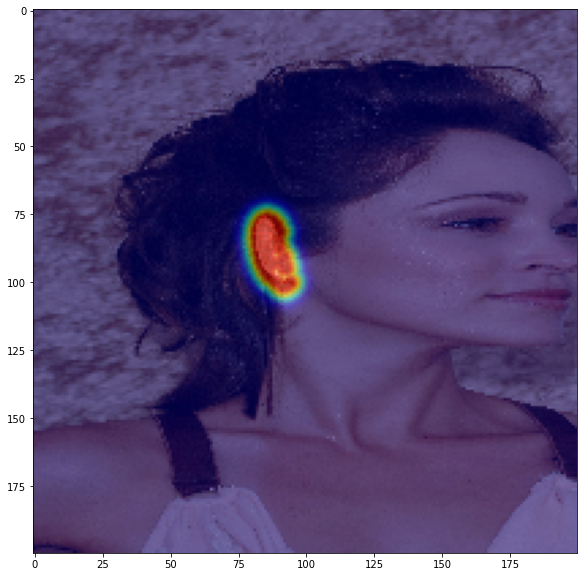

(200, 200, 1)


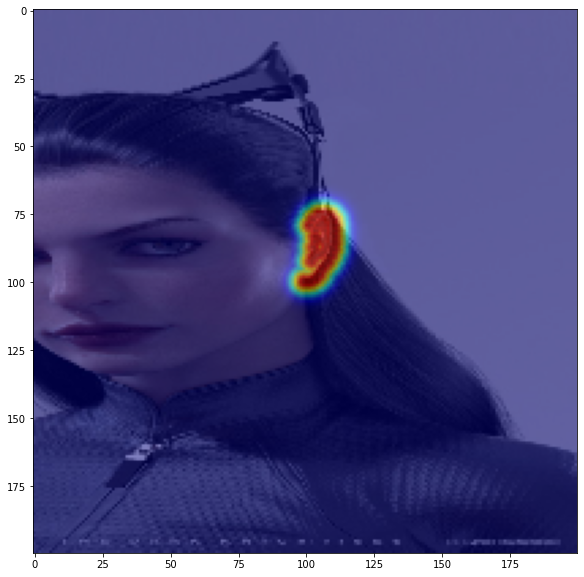

(200, 200, 1)


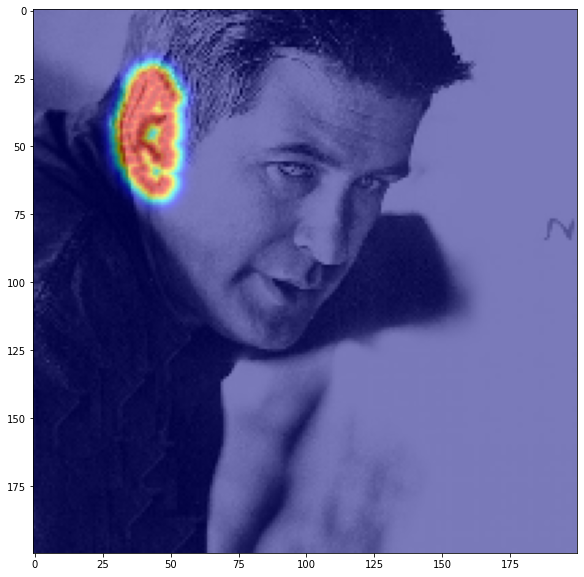

(200, 200, 1)


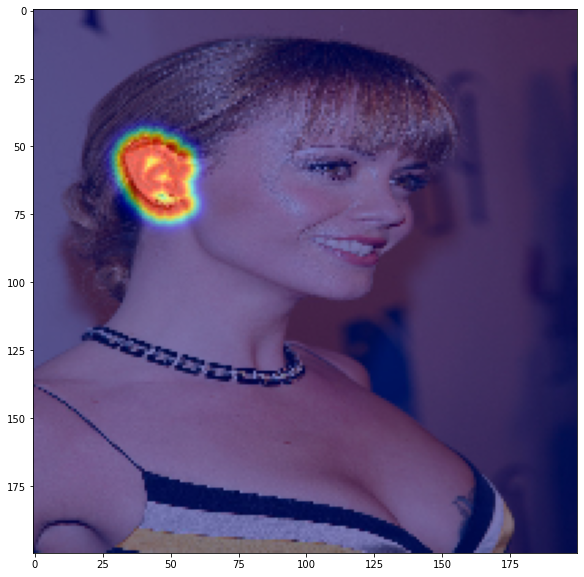

(200, 200, 1)


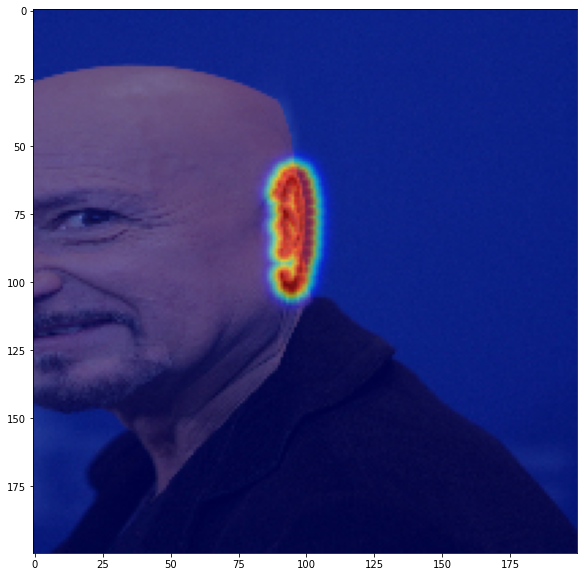

In [6]:
input_size_h = INPUT_SIZE/2
feat_size = model.get_layer('feature_map').output_shape[1]

#--------------------------------------

train_len = int(len(name_list)*split_rate)
test_len = len(name_list)-train_len
print(train_len, test_len)

train_dataset = tf.data.Dataset.from_tensor_slices(name_list[:train_len])
test_dataset = tf.data.Dataset.from_tensor_slices(name_list[train_len:])

def process_path(name):
    #image_path = data_dir+name+'.jpg'
    image_path = data_dir+name+'.png'
    image = tf.io.read_file(image_path)
    #image = tf.image.decode_jpeg(image)
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.cond(tf.shape(image)[-1] != 3,
                    lambda: tf.image.grayscale_to_rgb(image),
                    lambda: tf.identity(image))
    image_shape = tf.shape(image)
    
    #label = tf.numpy_function(_read_txt, [landmark_dir+name+'_pts.mat', image_shape], tf.float32)
    label = tf.numpy_function(_read_txt, [landmark_dir+name+'.txt', image_shape], tf.float32)
    
    image, label = tf.numpy_function(_shrink_image_one, [image, label], [tf.float32, tf.float32])
    image, label = tf.numpy_function(_crop_image_one, [image, label], [tf.float32, tf.float32])  
    #image, label = tf.numpy_function(_shift_image_one, [image, label], [tf.float32, tf.float32])
    image, label = tf.py_function(_flip_image_one, [image, label], [tf.float32, tf.float32])
    
    label = tf.numpy_function(_make_confidence_map, [label, MAP_SIGMA], tf.float32)
    
    image.set_shape([None, None, None])
    image = tf.image.resize(image, [INPUT_SIZE, INPUT_SIZE])
    
    #image.set_shape([INPUT_SIZE, INPUT_SIZE, 3])
    label.set_shape([MAP_SIZE, MAP_SIZE, LANDMARK_SIZE])
    #image = tf.reshape(image, shape=[input_size, input_size, 3])
    #label = tf.reshape(label, shape=[-1])
    
    return image, label

def _read_mat(file_path, input_shape):
    matfile = io.loadmat(file_path)
    norm = [input_shape[1]/2, input_shape[0]/2]
    label = ((matfile['pts_2d']-norm)/norm).astype(np.float32)
    return label

def _read_txt(file_path, input_shape):
    with open(file_path, 'r') as f:
        lines_list = f.readlines()
        temp = list(map(lambda l : list(map(float, l.split(' '))), lines_list[3:-1]))
        temp = np.array(temp)
    norm = [input_shape[1]/2, input_shape[0]/2]
    label = ((temp-norm)/norm).astype(np.float32)
    return label[LANDMARK_NUM]

def _make_confidence_map(label, sigma = 2.5):
    
    norm = [MAP_SIZE/2, MAP_SIZE/2]
    new_label = label*norm+norm
    
    grid_x = np.tile(np.arange(MAP_SIZE), (MAP_SIZE, 1))
    grid_y = np.tile(np.arange(MAP_SIZE), (MAP_SIZE, 1)).transpose()
    grid_x = np.tile(np.expand_dims(grid_x, axis=-1),LANDMARK_SIZE)
    grid_y = np.tile(np.expand_dims(grid_y, axis=-1),LANDMARK_SIZE)
    
    grid_distance = (grid_x - new_label[:,0]) ** 2 + (grid_y - new_label[:,1]) ** 2
    confidence_map = np.exp(-1 * grid_distance / sigma ** 2) # why 0.5?
    
    return confidence_map.astype(np.float32)

def _crop_image_one(img, label): # with label norm
    pad = 1
    
    img_h, img_w, img_c = img.shape
    
    idx = np.array([img_w/2, img_h/2])
    
    label = label*idx+idx
    
    label_x_info = np.array([min(label[:,0]), max(label[:,0])])
    label_y_info = np.array([min(label[:,1]), max(label[:,1])])
    
    ear_w = label_x_info[1]-label_x_info[0]
    ear_h = label_y_info[1]-label_y_info[0]
    
#     s_x = max(int(label_x_info[0]-ear_w*1-pad), 0)
#     e_x = min(int(label_x_info[0]+ear_w*8), img_w)
#     s_y = max(int(label_y_info[0]-ear_h*2-pad), 0)
#     e_y = min(int(label_y_info[0]+ear_h*3), img_h)

    s_x = max(int(label_x_info[0]-ear_w*10), 0)
    e_x = min(int(label_x_info[0]+ear_w*10), img_w)
    s_y = max(int(label_y_info[0]-ear_h*10), 0)
    e_y = min(int(label_y_info[0]+ear_h*10), img_h)

#     s_x = max(int(label_x_info[0]-ear_w*1-pad), 0)
#     e_x = min(int(label_x_info[1]+ear_w*1), img_w)
#     s_y = max(int(label_y_info[0]-ear_h*1-pad), 0)
#     e_y = min(int(label_y_info[1]+ear_h*1), img_h)
    
#     s_x = max(int(label_x_info[0]-pad), 0)
#     e_x = min(int(label_x_info[1]+pad), img_w)
#     s_y = max(int(label_y_info[0]-pad), 0)
#     e_y = min(int(label_y_info[1]+pad), img_h)

    c_img = img[s_y:e_y, s_x:e_x, :]
    c_label = label - np.array([s_x, s_y])
    
    new_img_h, new_img_w, _ = c_img.shape
    
    norm = [new_img_w/2, new_img_h/2]
    c_label = ((c_label-norm)/norm).astype(np.float32)
    return c_img, c_label

def _shrink_image_one(img, label):
    img_h, img_w, img_c = img.shape
    idx = np.array([img_w/2, img_h/2])
    label = label*idx+idx
    
    max_ratio = 4
    sh_ratio = np.random.randint(1,max_ratio)
    
    min_x = int(np.min(label[:,0]))
    max_x = int(np.max(label[:,0]))

    image_left = img[:,0:min_x,:]
    image_right = img[:,max_x:-1,:]
    image_mid = img[:,min_x:max_x:sh_ratio,:]

    sh_img = np.concatenate((image_left, image_mid, image_right), axis = 1)
    sh_label = (label-np.array([min_x,0]))/np.array([sh_ratio,1])+np.array([min_x,0])
    
    new_img_h, new_img_w, _ = sh_img.shape
    norm = [new_img_w/2, new_img_h/2]
    sh_label = ((sh_label-norm)/norm).astype(np.float32)
    
    return sh_img, sh_label
    
def _flip_image_one(img, label):
    c = np.random.randint(2)
    f_img, f_label = tf.cond(c==1,
                             lambda: (tf.image.flip_left_right(img), label * np.array([-1, 1])),
                             lambda: (img, label))
    #f_img = tf.image.resize(f_img, [input_size, input_size])
    return f_img, f_label

def _shift_image_one(img, label, padding = b'zero'):
    img_h, img_w, img_c = img.shape
    label_p, _ = label.shape
    
    if padding == b'ori': s_img = img[:]
    elif padding == b'zero': s_img = np.zeros_like(img, dtype=np.float32)
    s_label = np.expand_dims(label, axis=0)
    
    label_x_info = np.array([min(label[:,0]), max(label[:,0])])* img_w/2 + img_w/2
    label_y_info = np.array([min(label[:,1]), max(label[:,1])])* img_h/2 + img_h/2
    
    label_x_info = label_x_info.astype(np.int)
    label_y_info = label_y_info.astype(np.int)
    
    shift_x = np.random.randint(-label_x_info[0], img_w - label_x_info[1])
    shift_y = np.random.randint(-label_y_info[0], img_h - label_y_info[1])
    
    shift_x = min(shift_x, img_w//6)
    shift_y = min(shift_y, img_h//6)
    
    if shift_x < 0:
        get_x = (-shift_x, img_w)
        put_x = (0, img_w + shift_x)
    else:
        get_x = (0, img_w - shift_x)
        put_x = (shift_x, img_w)
    if shift_y < 0:
        get_y = (-shift_y, img_h)
        put_y = (0, img_h + shift_y)
    else:
        get_y = (0, img_h - shift_y)
        put_y = (shift_y, img_h)

    if padding == b'edge': s_img = np.pad(img[get_y[0]:get_y[1], get_x[0]:get_x[1], :], ((img_h-get_y[1],get_y[0]),(img_w-get_x[1],get_x[0]),(0,0)), mode='edge')
    else: s_img[put_y[0]:put_y[1], put_x[0]:put_x[1], :] = img[get_y[0]:get_y[1], get_x[0]:get_x[1], :]
    s_label = np.append(np.expand_dims(label[:,0] + (shift_x)/(img_w/2), axis = -1),
                          np.expand_dims(label[:,1] + (shift_y)/(img_h/2), axis = -1), axis = 1)
    
    return s_img, s_label

AUTOTUNE = tf.data.experimental.AUTOTUNE


train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


for image_raw, label_raw in train_dataset.take(1):
    images = image_raw.numpy()
    labels = label_raw.numpy()
    print(images.shape)
    print(labels.shape)
    
#     norm = np.array([INPUT_SIZE/2, INPUT_SIZE/2])
#     labels = labels.reshape(BATCH_SIZE, -1, 2)
#     labels = labels*norm + norm
    
    for i in range(len(images[:5])):
        
#         for x, y in labels[i]:
#             image_o = cv2.circle(images[i], (round(x), round(y)), 1, (1, 0, 0), -1)
        
        
        heatmap = tf.image.resize(labels[i], (INPUT_SIZE, INPUT_SIZE))
        #mask = np.amax(heatmap, axis=-1, keepdims=True) > 0.1
        mask = heatmap != 0#> 0.0001
        mask = np.amax(mask, axis=-1, keepdims=True)
        print(mask.shape)
        heatmap = cv2.applyColorMap(np.uint8(np.tile(np.amax(heatmap, axis=-1, keepdims=True), 3)*255), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        image_o = images[i]*0.5 + heatmap/255*0.5
        plt.figure(figsize=(10, 10))
        plt.imshow(image_o)#*(mask+0.5)/1.5)
        plt.show()
        #print(repr(images[i][:100]))
        #print()
        #print(label_text[i].numpy())

# 학습

In [7]:
train_step = train_len//BATCH_SIZE
test_step = test_len//BATCH_SIZE

history = model.fit(train_dataset,
                    epochs=EPOCH,
                    steps_per_epoch=train_step,
                    validation_steps=test_step,
                    validation_data=test_dataset,
                    verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Epoch 1/200
45/45 [==============================] - 21s 460ms/step - loss: 0.0010 - val_loss: 9.6599e-04
Epoch 2/200
45/45 [==============================] - 20s 446ms/step - loss: 9.6165e-04 - val_loss: 9.5884e-04
Epoch 3/200
45/45 [==============================] - 20s 440ms/step - loss: 9.5607e-04 - val_loss: 9.5335e-04
Epoch 4/200
45/45 [==============================] - 19s 412ms/step - loss: 9.4751e-04 - val_loss: 9.4212e-04
Epoch 5/200
45/45 [==============================] - 18s 409ms/step - loss: 9.2978e-04 - val_loss: 9.1577e-04
Epoch 6/200
45/45 [==============================] - 19s 422ms/step - loss: 8.9483e-04 - val_loss: 8.6330e-04
Epoch 7/200
45/45 [==============================] - 20s 440ms/step - loss: 8.3989e-04 - val_loss: 8.0812e-04
Epoch 8/200
45/45 [==============================] - 19s 418ms/step - loss: 7.7204e-04 - val_loss: 7.5032e-04
Epoch 9/200
45/45 [==============================] - 19s 420ms/step - loss: 7.1370e-04 - val_loss: 6.9909e-04
Epoch 10/200
4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 결과 확인

(10, 200, 200, 3)
(10, 100, 100, 55)


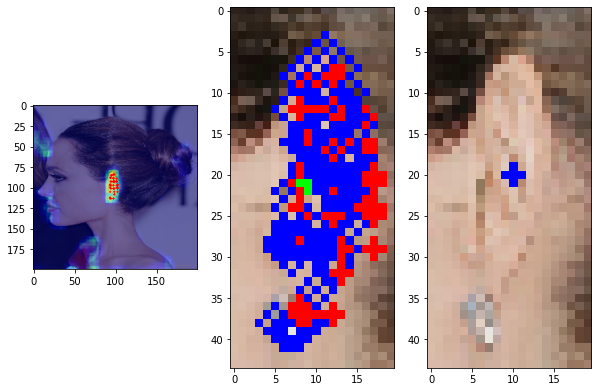

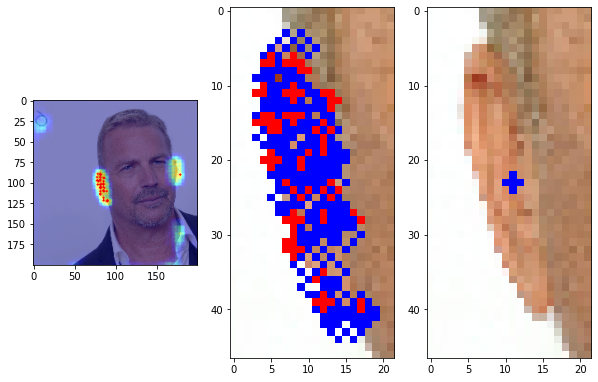

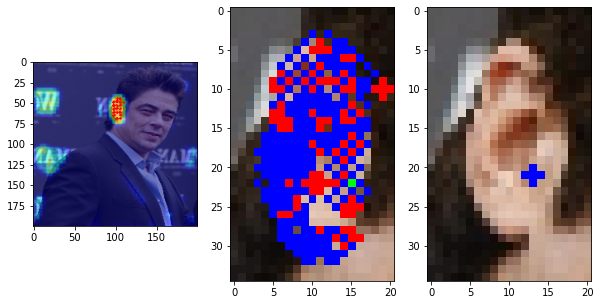

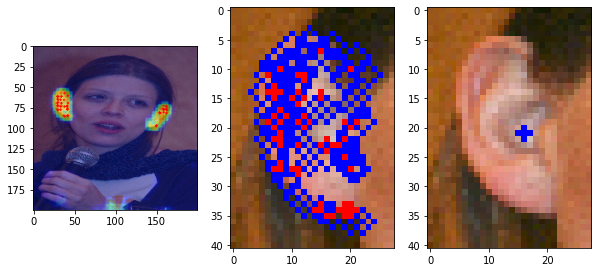

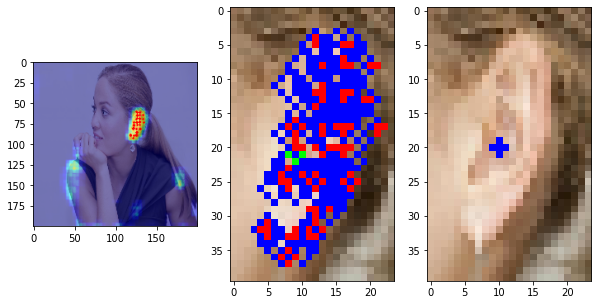

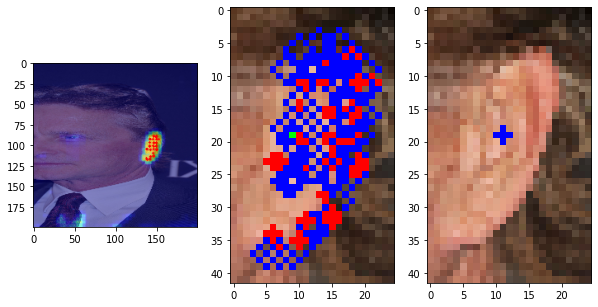

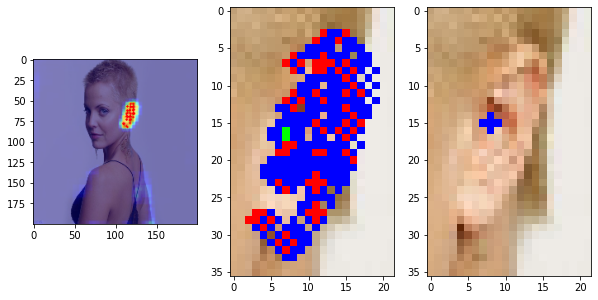

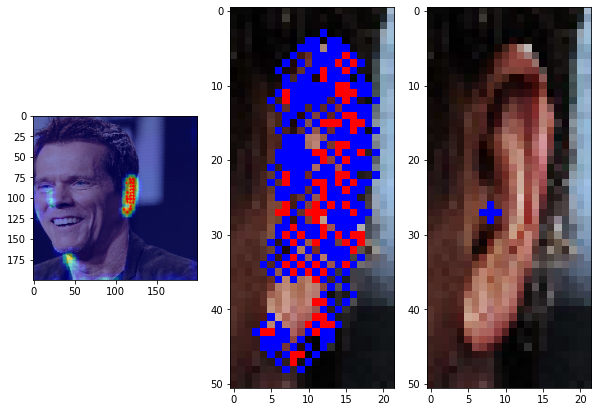

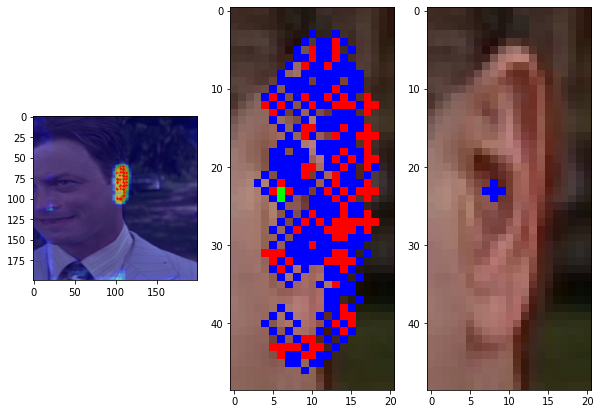

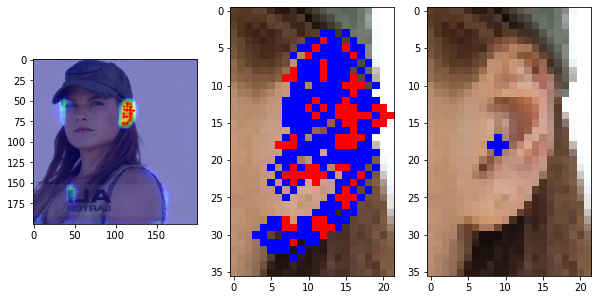

(10, 200, 200, 3)
(10, 100, 100, 55)


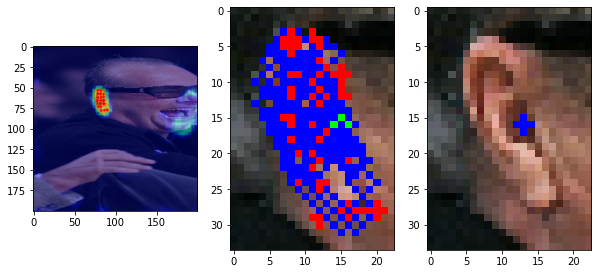

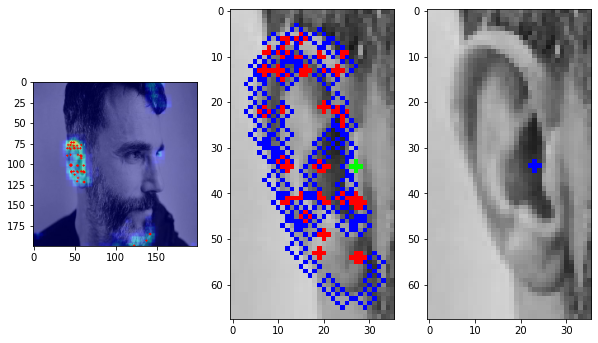

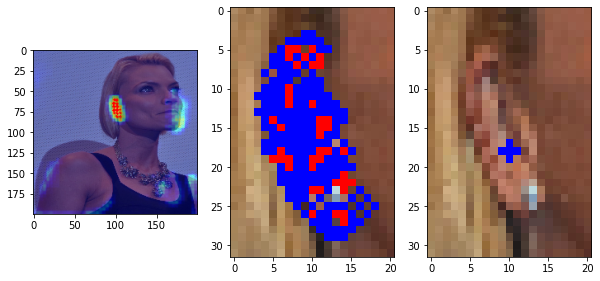

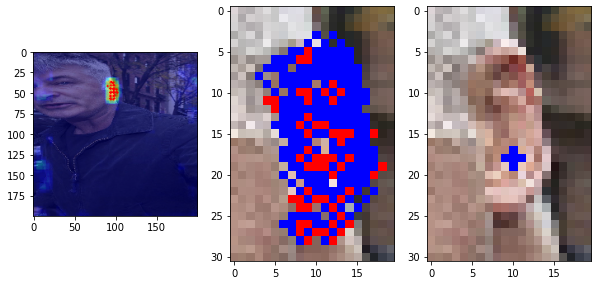

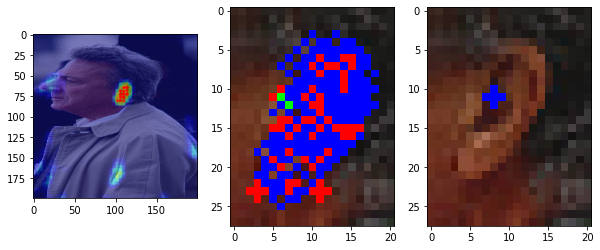

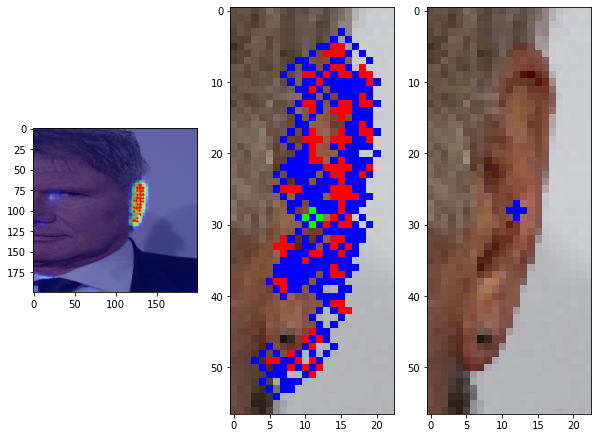

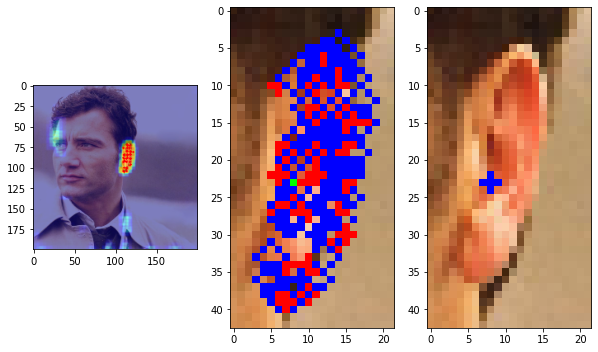

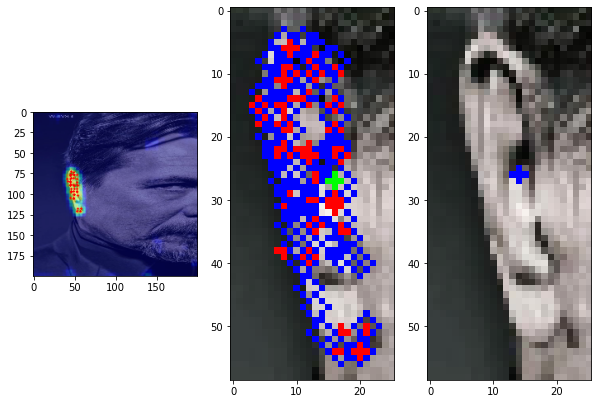

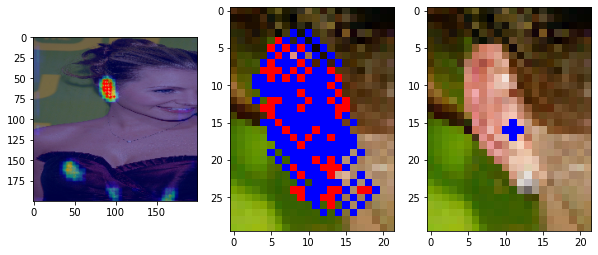

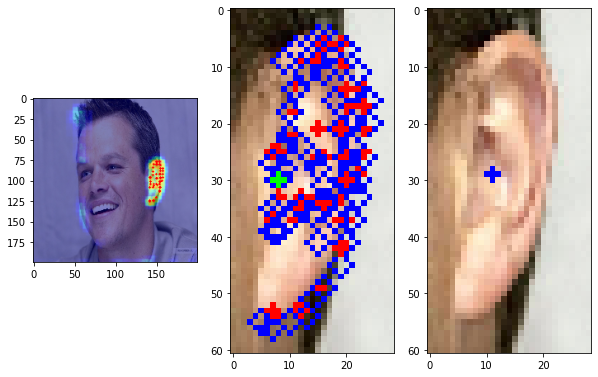

(10, 200, 200, 3)
(10, 100, 100, 55)


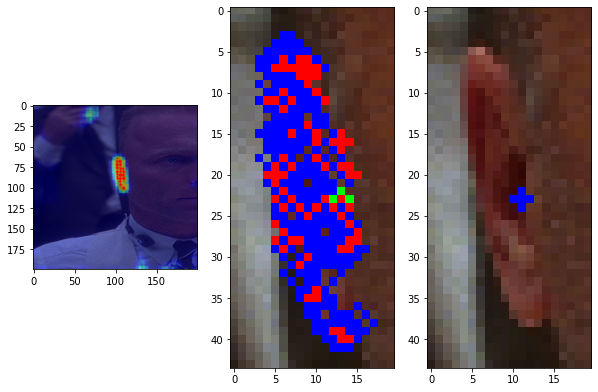

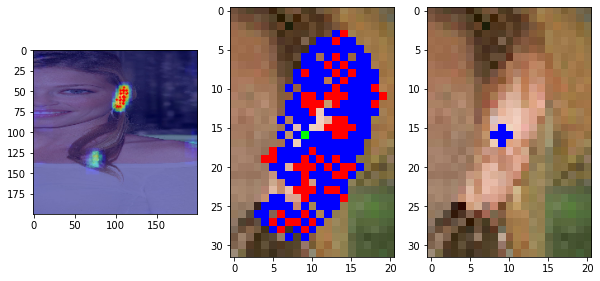

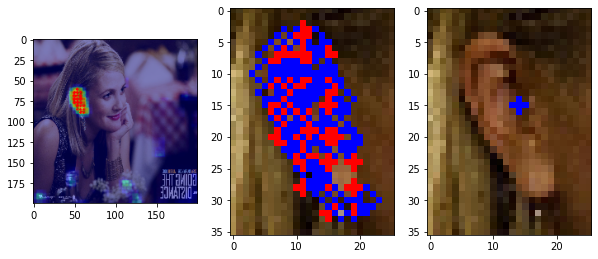

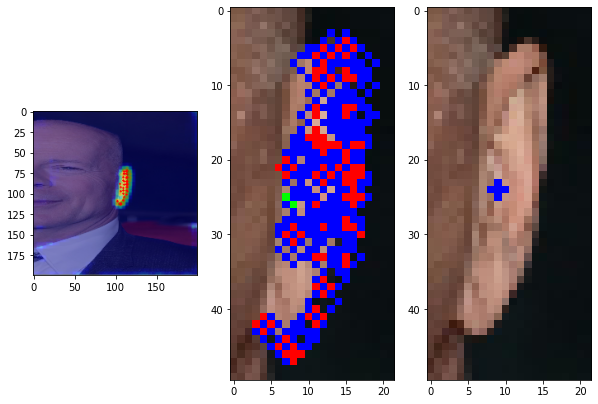

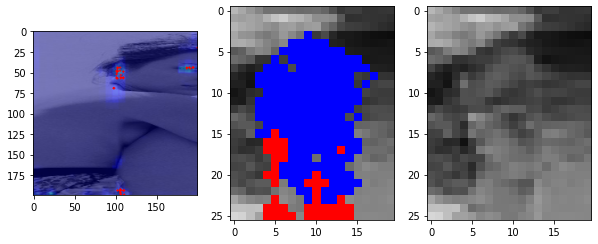

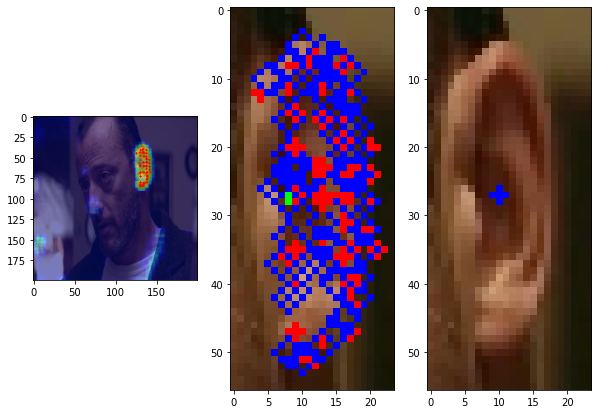

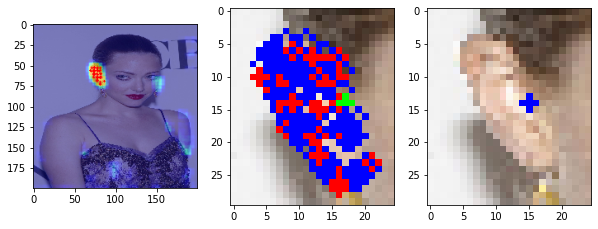

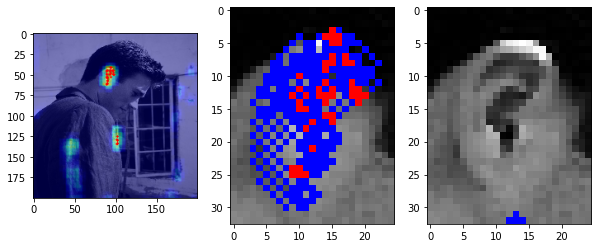

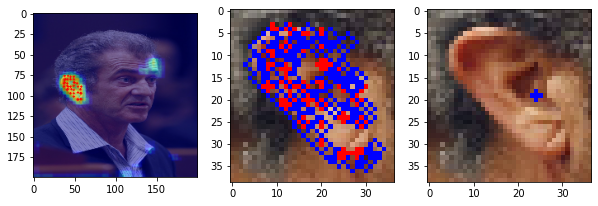

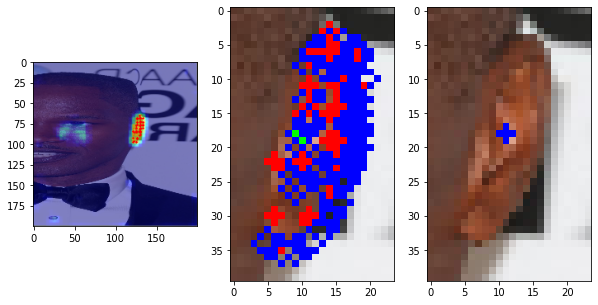

In [8]:
ear_hole = np.where(np.array(LANDMARK_NUM) == 36)[0]
ear_edge = np.where(np.array(LANDMARK_NUM) == 9)[0]

pred = tf.keras.backend.function([model.input], [model.get_layer('s6').output])
for image_raw, ture_label in test_dataset.take(3):
    images = image_raw.numpy()
    #labels = model.predict(images) 
    labels = pred([images])[0]
    print(images.shape)
    print(labels.shape)
    for i in range(BATCH_SIZE):
        heatmap = tf.image.resize(labels[i], (INPUT_SIZE, INPUT_SIZE))
        temp = np.argmax(np.reshape(heatmap, (-1,LANDMARK_SIZE)), axis = 0)
        heatmap = cv2.applyColorMap(np.uint8(np.tile(np.amax(heatmap, axis=-1, keepdims=True), 3)*255), cv2.COLORMAP_JET)
        #heatmap = cv2.applyColorMap(np.uint8(np.tile(np.expand_dims(heatmap[:,:,-1], axis = -1), 3)*255), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        image_o = images[i]*0.5 + heatmap/255*0.5
        image_ear = images[i][:]*1
        image_hole = images[i][:]*1
        #plt.imshow(image_o)
        #plt.show()
        
        #temp = np.amax(labels[i], axis=-1)
        #temp = np.argmax(labels[i].reshape(-1,LANDMARK_SIZE), axis = 0)
        #line = [[],[]]
        t_label = tf.image.resize(ture_label[i], (INPUT_SIZE, INPUT_SIZE))
        t_label = np.argmax(np.reshape(t_label, (-1,LANDMARK_SIZE)), axis = 0)
        min_x, max_x = INPUT_SIZE, 0
        min_y, max_y = INPUT_SIZE, 0
        mg = 5
        hole = []
        
        for num, idx in enumerate(temp):
            #x, y = (idx%feat_size)/feat_size, (idx//feat_size)/feat_size
            x, y = idx%INPUT_SIZE, idx//INPUT_SIZE
            t_x, t_y = t_label[num]%INPUT_SIZE, t_label[num]//INPUT_SIZE
            #x *= INPUT_SIZE
            #y *= INPUT_SIZE
            
            min_x, max_x = max(min(int(t_x)-mg, min_x), 0), min(max(int(t_x)+mg, max_x), INPUT_SIZE)
            min_y, max_y = max(min(int(t_y)-mg, min_y), 0), min(max(int(t_y)+mg, max_y), INPUT_SIZE)
            if num == ear_edge or num == ear_hole: hole.append([x, y])
            if num == ear_hole: image_ear = cv2.circle(image_ear, (round(x), round(y)), 1, (0, 1, 0), -1)
            else:        image_ear = cv2.circle(image_ear, (round(x), round(y)), 1, (1, 0, 0), -1)
            image_ear = cv2.circle(image_ear, (int(t_x), int(t_y)), 2, (0, 0, 1), 1)
            image_o = cv2.circle(image_o, (round(x), round(y)), 1, (1, 0, 0), -1)
            #line[0].append(x), line[1].append(y)
        #line[0].append(line[0][0]), line[1].append(line[1][0])
        #np.unravel_index(np.argmax(a, axis=None), a.shape)
        #print(temp.shape, temp)
        #print(loc)
        h_x, h_y = hole[0][0] + (hole[1][0] - hole[0][0])*0.8, hole[0][1] + (hole[1][1] - hole[0][1])*0.8
        image_hole = cv2.circle(image_hole, (int(h_x), int(h_y)), 1, (0, 0, 1), -1)
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1,3,1)
        plt.imshow(image_o)
        #plt.plot(line[0], line[1], '--', linewidth=1, color='firebrick')
        #plt.show()
        #print(min_x, max_x, min_y, max_y)
        plt.subplot(1,3,2)
        plt.imshow(image_ear[min_y:max_y, min_x:max_x,:])
        plt.subplot(1,3,3)
        plt.imshow(image_hole[min_y:max_y, min_x:max_x,:])
        plt.show()

In [9]:
model.save('saved_model_openpose_ears_ver7')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_openpose_ears_ver7/assets
